## Import Modules

In [18]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import os; import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
from matplotlib.cm import ScalarMappable
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image

# General utilities
import os
import glob
import warnings
import pandas as pd
import scipy as sp
import numpy as np
from tqdm import tqdm, trange
from natsort import natsorted
import multiprocessing as mp

# Image processing and IO
import tifffile as tiff
import skimage.io as io
from scipy import ndimage, misc
from skimage.feature import peak_local_max
import cv2

# Plotting and animation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as cbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.widgets import Slider
from matplotlib import animation, rc
from IPython.display import display, Image

# GPU and optimized operations
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage

# Statistical and optimization tools
from scipy.stats import chi2
from scipy.optimize import curve_fit

# Video processing
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Trackpy and related modules
import trackpy as tp

# Warnings configuration
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore outdated warnings

# Set up animation display
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128  # Set a higher threshold for .gif size



## Define functions
### Function for processing file paths in Windows

In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

### Clustering function

In [3]:
def cluster_optical_flow(us, vs, kernel_type='gaussian', kernel_size=21, normalize=False, verbose=False):    
    # create a gaussian kernel of size NxN
    N = kernel_size
    if kernel_type == 'gaussian':
        gaussian_window = sp.signal.windows.gaussian(N, std=5, sym=True)
        gaussian_window = gaussian_window.reshape(-1, 1)

        gaussian_kernel = gaussian_window @ gaussian_window.T
        gaussian_kernel[N // 2, N // 2] = 0  # Set the center value to 0
        kernel_gpu = cp.asarray(gaussian_kernel)  # Convert to CuPy array for GPU usage

    elif kernel_type == 'uniform':
        kernel_gpu = cp.ones((N, N), dtype=cp.float32)
        kernel_gpu[N // 2, N // 2] = 0
        kernel_gpu = kernel_gpu / cp.sum(kernel_gpu)

    # Convolve horizontal optical flow with the kernel
    cluster = []

    for u, v in tqdm(zip(us, vs), disable=(not verbose)):
        u_gpu = cp.asarray(u)
        v_gpu = cp.asarray(v)

        if normalize:
            norm = cp.sqrt(u_gpu**2 + v_gpu**2)
            norm[norm == 0] = 1.0  # Avoid division by zero
            u_gpu = u_gpu / norm
            v_gpu = v_gpu / norm
            u_gpu[cp.isnan(u_gpu)] = 0
            v_gpu[cp.isnan(v_gpu)] = 0

        # Perform convolution using CuPy's GPU-based convolution
        u_gpu = u_gpu * cpx_ndimage.convolve(u_gpu, kernel_gpu, mode='constant', cval=0.0)
        v_gpu = v_gpu * cpx_ndimage.convolve(v_gpu, kernel_gpu, mode='constant', cval=0.0)

        # Append the sum of the convolved u and v to the cluster
        cluster.append(u_gpu.get() + v_gpu.get())  # Move the result back to CPU memory

    return cluster

### Remove static and discontinuous tracks

In [4]:
def remove_static_tracks(df, movement_threshold=1.0):
    """
    Removes static tracks based on the total displacement of particles.
    
    Parameters:
    - df: pandas DataFrame, contains the particle tracking data with 'x', 'y', and 'particle' columns
    - movement_threshold: float, the minimum total displacement required for a track to be considered valid
    
    Returns:
    - filtered DataFrame containing only the tracks with total displacement greater than the movement threshold
    """
    valid_particles = []

    # Group by 'particle' to process each track separately
    for particle_id, track in df.groupby('particle'):
        # Get the x and y positions and compute the differences
        x_diff = track['x'].diff().dropna()
        y_diff = track['y'].diff().dropna()

        # Calculate the Euclidean distance (displacement) between consecutive points
        displacement = np.sqrt(x_diff**2 + y_diff**2)

        # Calculate the total displacement for this track
        total_displacement = displacement.sum()

        # If the total displacement is greater than the movement threshold, keep the track
        if total_displacement > movement_threshold:
            valid_particles.append(particle_id)

    # Filter the DataFrame to keep only valid particles
    return df[df['particle'].isin(valid_particles)]


# Combine the previous 2 functions to remove discontinuous and static tracks
def filter_tracks(df, movement_threshold=1.0):
    # Drop NaNs from the dataframe before processing
    df = df.dropna(subset=['x', 'y', 'frame'])
    
    # df_no_gaps = remove_discontinuous_tracks(df)  # Remove tracks with gaps
    df_filtered = remove_static_tracks(df, movement_threshold)  # Remove static tracks
    
    return df_filtered

## Load the mask and Optical Flow results

In [5]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1');
file_name = 'cortical_div2_timelapse2_1_jttr_blch_corr.tiff'
resolution = 2.7778   #px./um
frame_interval = 2.00137  #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 

of_path = data_folder+'\\Op_flow'
of_list = natsorted(os.listdir(of_path))
# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[mask==0]=np.NaN

n_frames = (len(of_list))  # number of time-frames in the movie
# y_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[0]
# x_span = np.shape(np.load(of_path+'\\0.npz')['vy'])[1]
y_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[0]
x_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[1]

vy_all = np.zeros((n_frames, y_span, x_span))

vx_all = np.zeros((n_frames, y_span, x_span))

for i in tqdm(range(len(of_list))):
    # matr = np.load(of_path+'\\'+of_list[i])
    matr = sio.loadmat(of_path+'\\'+of_list[i])
    vy_all[i,:,:] = matr['vy']
    vx_all[i,:,:] = matr['vx']

cluster = cluster_optical_flow(vx_all, vy_all, kernel_type='gaussian', kernel_size=11, normalize=False, verbose=False)  
# kernel_size was 11 earlier

100%|██████████| 300/300 [00:00<00:00, 310.98it/s]


### Visualize the cluster peaks for a time-frame 
* We get an idea about the peak size

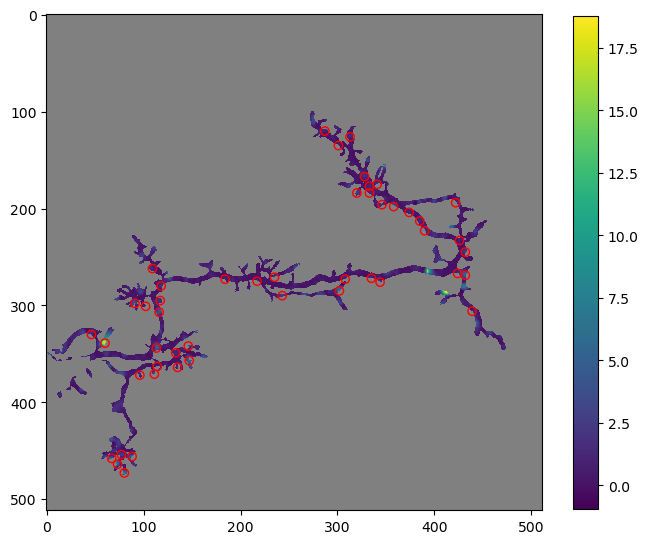

In [6]:
ind = 30   # choose a frame-index
image = cluster[ind]*mask

# Apply maximum filter to detect local maxima
filtered_image = maximum_filter(image, size=10)  # Adjust the size based on expected peak size
peaks = (image == filtered_image)  # Peaks are where the original image equals the maximum filter result

# Label the peaks
labeled_peaks, num_features = label(peaks)
# Mask NaN values to display them with a specific color
# masked_image = np.ma.masked_invalid(|image)

# Create a colormap that shows NaN values as a chosen color
cmap = plt.cm.viridis
cmap.set_bad(color='gray')  # Set the color for NaN values to a chosen color

# Plot the image and overlay the peaks
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(image, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(im, ax=ax, shrink = 0.8)   # Create a colorbar

# Mark the peaks with red dots
for i in range(1, num_features + 1):
    slice_y, slice_x = find_objects(labeled_peaks == i)[0]
    ax.scatter((slice_x.start + slice_x.stop - 1) / 2, (slice_y.start + slice_y.stop - 1) / 2, facecolor='none', color='r')

plt.show()
# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\peak_identification.svg', format='svg', bbox_inches='tight')

### Check threshold for a peak (we are using 1.0 by default)

In [7]:
yo = np.zeros((n_frames,1))
for i in tqdm(range(n_frames)):
    yo[i] = (np.nanpercentile(cluster[i]*mask,50))
print(f'Mean Value: {np.nanmean(yo):.2f}')

100%|██████████| 300/300 [00:00<00:00, 356.53it/s]

Mean Value: 0.51


## Peak Detection over time
### Extract the trajectories

In [8]:
# Parameters for particle detection
diameter = 5  # Approximate size of the particle in pixels
minmass = 1.0  # Minimum integrated brightness (mass) of a particle to be considered (we get an idea from the previous cell)
search_range = 5  # Maximum displacement between frames in pixels

# A list to store particle locations for each frame
particle_positions = []

# Loop through each 2D frame to detect particles
for t in tqdm(range(n_frames)):
    frame = np.nan_to_num(cluster[t] * mask, nan=0)  # Get the 2D frame from the 3D stack (apply mask if needed)
    # Detect particles with sub-pixel accuracy in this frame
    particles = tp.locate(frame, diameter=diameter, minmass=minmass, separation=15)
    
    # Add the frame number to each detected particle's data
    particles['frame'] = t
    
    # Store the detected particles
    particle_positions.append(particles)

# Combine all particle positions across frames into a single DataFrame
peaks_df = pd.concat(particle_positions)

# Use trackpy to link the particles over time
tp_trajectories = tp.link(peaks_df, search_range=search_range, memory=1)

# Now tp_trajectories contains sub-pixel accurate positions and is linked over time
# print(tp_trajectories.head())

Frame 299: 66 trajectories present.


## Post-processing of the tracks:
### Step-i) Prunning out small tracks: We need a duration of atleast 10 timeframes
### Step-ii) Getting rid of the static and discontinuous tracks

In [9]:
# Filter out tracks with less than 3 frames
tp_trajectories_pruned = tp.filter_stubs(tp_trajectories, 10)  

movement_threshold = 3.0  # Adjust this threshold as needed
tp_trajectories_filtered = filter_tracks(tp_trajectories_pruned, movement_threshold)

# Calculate the duration of each track
track_duration = tp_trajectories_filtered.groupby('particle')['frame'].apply(lambda x: x.max() - x.min() + 1).reset_index(name='track_duration')
short_tracks = track_duration[track_duration['track_duration'] < 10]  # Filter tracks with less than 3 frames
print(short_tracks)   # Display tracks with less than10 frames


Empty DataFrame
Columns: [particle, track_duration]
Index: []


### Visualizing the filtered tracks 

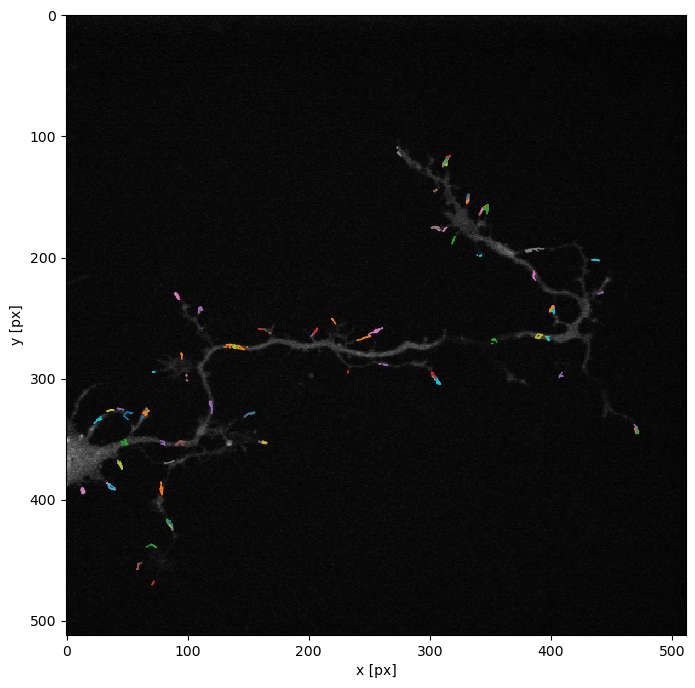

In [10]:
# Visualize the trajectories
fig, ax = plt.subplots(figsize = (8,12))  # Create a figure and axes
tp.plot_traj(tp_trajectories_filtered,superimpose=img[0],ax=ax)  # Pass the axes to the plot_traj function

ax.set_aspect('equal')  # Set equal axis scaling to ensure equal aspect ratio
plt.show()

# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\filtered_tracks.png', format='png', bbox_inches='tight', dpi = 600)

In [21]:
# Define the helper functions (apply_cmap, nparray_to_video, make_tracks_movie) here...
# Video processing
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage


def apply_cmap(data, cmap='gray', clim='auto'):
    """Apply a colormap to a numpy array."""
    if clim == 'auto':
        clim = data.min(), data.max()
    sm = ScalarMappable(Normalize(*clim, clip=True), cmap)
    rgba = [sm.to_rgba(d, bytes=True) for d in data]
    return rgba

def nparray_to_video(fname, data, clim='auto', cmap=None, codec='h264', fps=24, ffmpeg_params=['-pix_fmt', 'yuv420p']):
    """
    Save a 3D (t, y, x) numpy array to disk as a movie after applying a colormap.
    """
    dur = data.shape[0] / fps
    if cmap is not None:
        data_rgba = apply_cmap(data, cmap=cmap, clim=clim)
    else:
        data_rgba = data
    clip = ImageSequenceClip([d for d in data_rgba], fps=fps)
    clip.set_duration(dur).write_videofile(fname, audio=False, codec=codec, fps=fps, ffmpeg_params=ffmpeg_params)

def make_tracks_movie(imgs, tracks, save_name, fps=12, cmap='gray', clim='auto'):
    """
    Create a movie of the images with the tracks overlaid on top.

    Parameters
    ----------
    imgs : np.ndarray
        t+2D array of images (frames, height, width).
    tracks : pd.DataFrame
        DataFrame of tracks with columns ['x', 'y', 'frame', 'particle'].
    save_name : str
        Name of the file to save the movie to (e.g., 'movie.mp4').
    fps : int, optional
        Frames per second for the output movie.
    cmap : str, optional
        Colormap for the image frames.
    clim : tuple or 'auto', optional
        Color limits for the image intensity.
    """
    ims = []  # To store frame-by-frame images with overlaid tracks
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    ax.axis('off')  # Turn off axis labels
    fig.tight_layout(pad=0)

    for i in trange(imgs.shape[0]):
        ax.imshow(imgs[i], cmap=cmap, animated=True)

        # Set clim (color limits) based on the 'auto' argument
        if clim == 'auto':
            clim = (np.min(imgs[i]), np.max(imgs[i]))  # Auto range based on the current frame's values
        ax.imshow(imgs[i], cmap=cmap, clim=clim, animated=True)

        for p in tracks['particle'].unique():
            particle_tracks = tracks[(tracks['particle'] == p) & (tracks['frame'] <= i)]
            ax.plot(particle_tracks['x'], particle_tracks['y'], color='red', lw=1)

        ax.scatter(
            tracks[tracks['frame'] == i]['x'], 
            tracks[tracks['frame'] == i]['y'], 
            color='black', s=2
        )

        ims.append(mplfig_to_npimage(fig))
        ax.clear()

    plt.close(fig)  # Close the figure to free memory
    video_data = np.array(ims)  # Convert the frames into a NumPy array
    nparray_to_video(save_name, video_data, clim=clim, cmap=cmap, codec='h264', fps=fps)

make_tracks_movie(img, tp_trajectories_filtered, data_folder+'\\tracked_movie_fastest.mp4', fps=50, cmap='gray', clim='auto')


100%|██████████| 301/301 [02:13<00:00,  2.26it/s]


Moviepy - Building video E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1\tracked_movie_fastest.mp4.
Moviepy - Writing video E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1\tracked_movie_fastest.mp4



Moviepy - Done !
Moviepy - video ready E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1\tracked_movie_fastest.mp4


In [15]:
data_folder

'E:\\\\Spandan\\\\2D_Neurons_Paper\\\\Glass\\\\div2\\\\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1'

### Visualizing tracks as scatter points

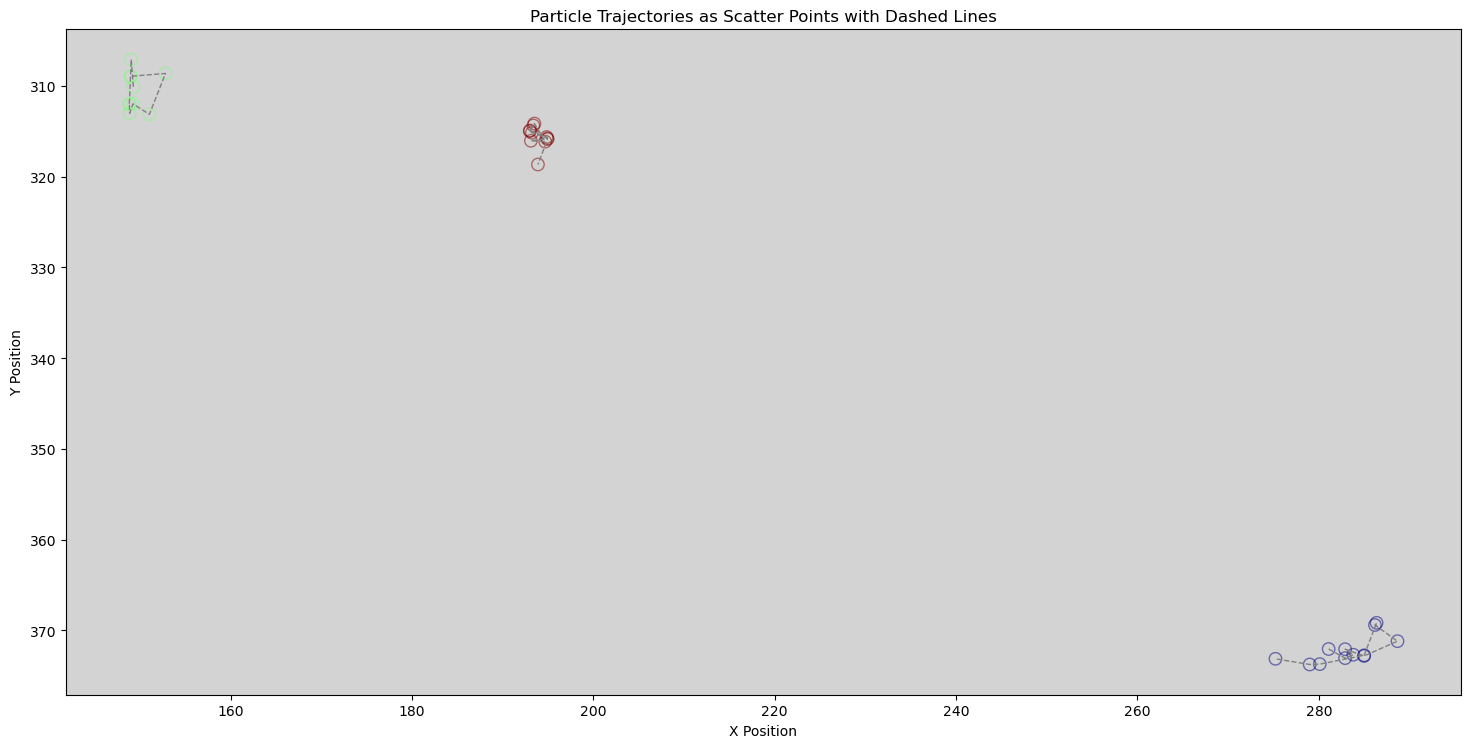

In [10]:
fig, ax = plt.subplots(figsize = (18,12))
colormap = cm.get_cmap('jet')

# Set figure background color to grey
ax.set_facecolor('lightgrey')  # Change to your preferred shade of grey

num_particles = tp_trajectories_filtered['particle'].nunique() # Determine the number of unique particles
colors = colormap(np.linspace(0, 1, num_particles))   # Create a list of colors from the colormap

# Create a color map for the particles
particle_color_map = dict(zip(tp_trajectories_filtered['particle'].unique(), colors))

# Group by particle ID to plot each track separately
for particle_id, track in tp_trajectories_filtered.groupby('particle'):

    # Get color for the current particle
    color = particle_color_map[particle_id]
    
    # Plot scatter points for each frame in the trajectory
    ax.scatter(track['x'], track['y'], s=80, facecolor='none', alpha=0.5, color=color)

    # Connect the points with a dashed line
    ax.plot(track['x'], track['y'], linestyle='--', linewidth=1, color='gray')

# Set axis labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Particle Trajectories as Scatter Points with Dashed Lines')

# Ensure equal axis scaling
ax.set_aspect('equal')
ax.invert_yaxis()

# Show the plot
plt.show()

# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\scatter_tracks.svg', format='svg', bbox_inches='tight')



## Old Track properties calculationfunction (velocities, length, duration)
### Weighted distribution function

In [11]:
def calculate_track_metrics(tp_trajectories_filtered):
    """
    Calculate and store instantaneous frame-to-frame shifts (x, y, and frame), displacement, instantaneous velocity,
    total distance traversed, total displacement from initial position, total duration, average velocity of tracks,
    and the direction (angle) of track progression at each time step.

    Parameters:
    - tp_trajectories_filtered: pandas DataFrame, particle tracking data with 'x', 'y', 'frame', and 'particle' columns

    Returns:
    - tp_trajectories_filtered: pandas DataFrame, the original DataFrame with additional columns for the computed metrics
    
    The resulting DataFrame 'tp_trajectories_filtered' will contain the following columns:

    ### Instantaneous Calculations:
    1. **particle**: Unique identifier for each track (particle).
    2. **frame**: Time frame corresponding to the observation of a particle.
    3. **x**: x-coordinate of the particle in the given frame.
    4. **y**: y-coordinate of the particle in the given frame.
    5. **x_shift**: Frame-to-frame change in x-coordinate (`x[n] - x[n-1]`), filled with 0 for the first frame.
    6. **y_shift**: Frame-to-frame change in y-coordinate (`y[n] - y[n-1]`), filled with 0 for the first frame.
    7. **frame_shift**: Frame-to-frame difference in frame number, filled with 1 for the first frame.
    8. **displacement**: Euclidean distance between consecutive frames, representing instantaneous movement.
    9. **inst_velocity**: Instantaneous velocity, calculated as displacement divided by frame_shift.
    10. **angle**: The direction of movement (in radians), calculated using `arctan2(y_shift, x_shift)`.
    
    ### Track-Level Calculations:
    11. **track_length**: Total distance traveled by the particle over its entire track (sum of displacements).
    12. **track_duration**: Total number of unique frames in which the particle appears (duration of the track).
    13. **x_start**: x-coordinate of the particle at the start of the track.
    14. **y_start**: y-coordinate of the particle at the start of the track.
    15. **x_end**: x-coordinate of the particle at the end of the track.
    16. **y_end**: y-coordinate of the particle at the end of the track.
    17. **frame_start**: First frame in which the particle is observed.
    18. **frame_end**: Last frame in which the particle is observed.
    19. **distance**: Straight-line distance between the start and end positions of the particle.
    20. **avg_velocity**: Average velocity of the particle across its entire track, calculated as distance / track_duration.
    21. **avg_inst_velocity**: Average of the instantaneous velocities for each particle.
    """

    # 1. Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered.groupby('particle')['x'].diff()
    tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered.groupby('particle')['y'].diff()
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered.groupby('particle')['frame'].diff()

    # Fill NaN values for the first frame of each track
    tp_trajectories_filtered['x_shift'] = tp_trajectories_filtered['x_shift'].fillna(0)
    tp_trajectories_filtered['y_shift'] = tp_trajectories_filtered['y_shift'].fillna(0)
    tp_trajectories_filtered['frame_shift'] = tp_trajectories_filtered['frame_shift'].fillna(1)  # Assume frame_shift is 1 for the first frame

    # 2. Calculate instantaneous displacement magnitude (distance per frame)
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)

    # 3. Calculate instantaneous velocity magnitude (displacement per frame)
    tp_trajectories_filtered['inst_velocity'] = tp_trajectories_filtered['displacement'] / tp_trajectories_filtered['frame_shift']

    # Remove NaN values from displacement and velocity
    tp_trajectories_filtered = tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'])

    # 4. Calculate the Total Track Length (sum of displacements per particle)
    track_lengths = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index(name='track_length')

    # 5. Calculate the Track Duration (count of unique frames per particle)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')

    # 6. Calculate start and end locations, and frames for each particle
    track_properties = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last'),
        frame_start=('frame', 'first'),
        frame_end=('frame', 'last')
    ).reset_index()

    # 7. Calculate the total displacement from initial to final position
    track_properties['distance'] = np.sqrt((track_properties['x_end'] - track_properties['x_start'])**2 +
                                           (track_properties['y_end'] - track_properties['y_start'])**2)

    # 8. Calculate average velocity (total displacement divided by track duration)
    track_properties['avg_velocity'] = track_properties['distance'] / track_duration['track_duration']

    # 9. Calculate the direction (angle) of movement at each time step
    # Negate y_shift to account for the image coordinate system
    tp_trajectories_filtered['angle'] = np.arctan2(-tp_trajectories_filtered['y_shift'], tp_trajectories_filtered['x_shift'])

    # Replace angles where there's no movement
    tp_trajectories_filtered['angle'] = np.where(
    (tp_trajectories_filtered['x_shift'] == 0) & (tp_trajectories_filtered['y_shift'] == 0), np.nan, 
        tp_trajectories_filtered['angle'])

    # 10. Calculate the average instantaneous velocity for each particle
    avg_inst_velocity = tp_trajectories_filtered.groupby('particle')['inst_velocity'].mean().reset_index(name='avg_inst_velocity')

    # Merge the calculated average instantaneous velocity back into the main DataFrame
    tp_trajectories_filtered = pd.merge(tp_trajectories_filtered, avg_inst_velocity, on='particle')

    # 11. Merge the calculated properties back into the original dataframe
    track_properties = pd.merge(track_properties, track_lengths, on='particle')
    track_properties = pd.merge(track_properties, track_duration, on='particle')

    # Optionally merge track_properties back with the original dataframe if you want to keep all the data
    tp_trajectories_filtered = pd.merge(tp_trajectories_filtered, track_properties, on='particle')

    return tp_trajectories_filtered

tp_trajectories_final = calculate_track_metrics(tp_trajectories_filtered)

## Latest Function (unweighted)

In [39]:
def calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval):
    """
    Calculate and store instantaneous shifts, displacements, velocities, total track properties, 
    and other metrics for each particle's trajectory.

    Parameters:
    - tp_trajectories_filtered (pandas DataFrame): Particle tracking data with 'x', 'y', 'frame', and 'particle' columns.
    - resolution (float): Spatial resolution to convert units as required (e.g., pixels to microns).
    - frame_interval (float): Time interval between frames to calculate velocities and track duration.

    Returns:
    - tp_trajectories_filtered (pandas DataFrame): Input DataFrame with added columns:
        - 'x_shift': x-direction shift per frame for each particle.
        - 'y_shift': y-direction shift per frame for each particle.
        - 'frame_shift': Number of frames between positions in the trajectory.
        - 'displacement': Frame-to-frame displacement (Euclidean distance) in pixels.
        - 'inst_velocity': Instantaneous velocity per frame (#px./frame) for each particle.
    - track_properties (pandas DataFrame): Aggregated track-level metrics per particle, including:
        - 'track_length': Total track length, i.e., cumulative distance traveled by each particle (microns).
        - 'track_duration': Total duration of each particle's trajectory (seconds).
        - 'distance': Net displacement from initial to final position (microns).
        - 'avg_velocity': Average net velocity (net displacement divided by total time, in microns/min).
        - 'inst_velocity': Average instantaneous velocity (total track length divided by total time, in microns/min).
        - 'sinuosity': Measure of track straightness (track length divided by net displacement).
    """

    # Calculate Instantaneous Shifts (x, y, and frame)
    tp_trajectories_filtered['x_shift'] = (tp_trajectories_filtered.groupby('particle')['x'].diff().fillna(0)) 
    tp_trajectories_filtered['y_shift'] = (tp_trajectories_filtered.groupby('particle')['y'].diff().fillna(0)) 
    tp_trajectories_filtered['frame_shift']  = tp_trajectories_filtered.groupby('particle')['frame'].diff().fillna(1)
    
    # Calculate instantaneous displacement and velocity
    tp_trajectories_filtered['displacement'] = np.sqrt(tp_trajectories_filtered['x_shift']**2 + tp_trajectories_filtered['y_shift']**2)
    tp_trajectories_filtered['inst_velocity'] = (tp_trajectories_filtered['displacement'] /
                                                 tp_trajectories_filtered['frame_shift'])
    
    # Drop NaN values from displacement and velocity
    tp_trajectories_filtered.dropna(subset=['displacement', 'inst_velocity'], inplace=True)


    # Calculate track-level metrics: total distance traveled (track length), track duration, distance, average velocity, and sinuosity   
    
    # Calculate track length (total distance traversed) by summing displacements for each particle
    track_properties = tp_trajectories_filtered.groupby('particle')['displacement'].sum().reset_index()   
    track_properties['track_length'] = track_properties['displacement'] / resolution
    
    # Dropping the 'displacement' column from the new dataframe
    track_properties = track_properties.drop(columns='displacement')
    
    # Calculate track duration (total frames converted to seconds)
    track_duration = tp_trajectories_filtered.groupby('particle')['frame'].nunique().reset_index(name='track_duration')
    track_duration['track_duration'] = (track_duration['track_duration']-1) * frame_interval
    
    # Merge the track_duration back into track_properties DataFrame
    track_properties = track_properties.merge(track_duration[['particle', 'track_duration']], on='particle', how='left')

    # Calculate total displacement (net distance between start and end positions)
    track_metrics = tp_trajectories_filtered.groupby('particle').agg(
        x_start=('x', 'first'),
        y_start=('y', 'first'),
        x_end=('x', 'last'),
        y_end=('y', 'last'),
        frame_start=('frame', 'first'),
        frame_end=('frame', 'last')
    ).reset_index()
    
    # Calculate total displacement (net distance between start and end positions)
    track_properties['distance'] = np.sqrt((track_metrics['x_end'] - track_metrics['x_start'])**2 +
                                            (track_metrics['y_end'] - track_metrics['y_start'])**2) / resolution
    
    # Calculate average net speed (net displacement / total time)
    track_properties['avg_velocity'] = track_properties['distance'] * 60 / track_properties['track_duration']
    
    # Calculate the average instantaneous velocity (track length / total time)
    track_properties['inst_velocity'] =  track_properties['track_length'] * 60 / track_properties['track_duration']

    # Calculate sinuosity (track length / net displacement)
    track_properties['sinuosity'] = track_properties['track_length'] / track_properties['distance']
    
    # Now track_metrics contains 'distance', 'avg_velocity', 'avg_inst_velocity', and 'sinuosity'


    return tp_trajectories_filtered, track_properties
    print("Trajectories and track properties calculated and stored.")

[tp_trajectories_final, track_properties_final] = calculate_track_metrics(tp_trajectories_filtered, resolution, frame_interval)

In [40]:
tp_trajectories_final

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
33,372.073779,281.081755,14.547949,1.336653,0.356993,2.117648,112.936351,0.000308,33,517,0.000000,0.000000,1.0,0.000000,0.000000
34,373.077970,282.899752,11.458245,1.343300,0.424321,1.375557,74.481553,0.000510,34,517,1.817998,1.004192,1.0,2.076901,2.076901
35,372.705435,283.798913,10.082492,1.329433,0.166577,1.249352,68.271497,0.000403,35,517,0.899161,-0.372536,1.0,0.973279,0.973279
36,372.095725,282.896840,13.446337,1.302700,0.255292,1.637054,81.122923,0.000794,36,517,-0.902073,-0.609710,1.0,1.088798,1.088798
38,372.840336,284.987395,2.478527,1.214409,0.251156,0.406145,16.552629,0.001934,38,517,2.090555,0.744611,2.0,2.219204,1.109602
39,371.210101,288.672727,4.428061,1.180652,0.566121,0.894558,28.894423,0.001110,39,517,3.685332,-1.630235,1.0,4.029807,4.029807
40,369.428436,286.187678,13.728844,1.294538,0.210257,2.030047,92.077501,0.000326,40,517,-2.485050,-1.781665,1.0,3.057744,3.057744
41,369.186147,286.366883,8.152969,1.263456,0.339867,1.279416,48.872234,0.000601,41,517,0.179205,-0.242289,1.0,0.301361,0.301361
42,372.766092,284.999093,11.506928,1.230100,0.069400,1.856966,73.344283,0.000354,42,517,-1.367790,3.579945,1.0,3.832344,3.832344


In [41]:
track_properties_final

,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,517,9.902476,22.01507,2.145864,5.848351,26.988265,4.614679
1,1661,7.589256,18.01233,0.414668,1.381280,25.280204,18.302013
2,1746,5.334668,20.01370,1.560335,4.677802,15.993048,3.418924


In [12]:
tp_trajectories_final.particle.unique()

array([ 517, 1661, 1746], dtype=int64)

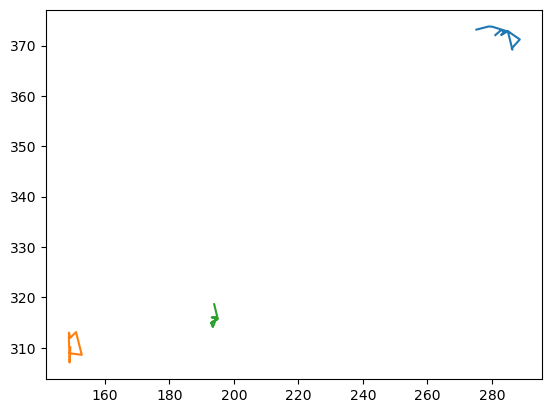

In [13]:
for p in tp_trajectories_final.particle.unique():
    plt.plot(tp_trajectories_final.query('particle==@p')['x'],tp_trajectories_final.query('particle==@p')['y'])

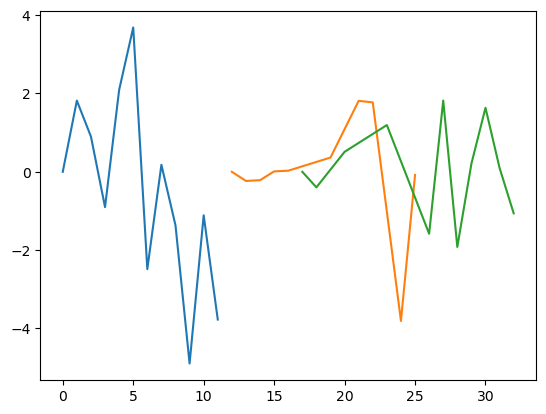

In [14]:
for p in tp_trajectories_final.particle.unique():
    plt.plot(tp_trajectories_final.query('particle==@p')['x_shift'])

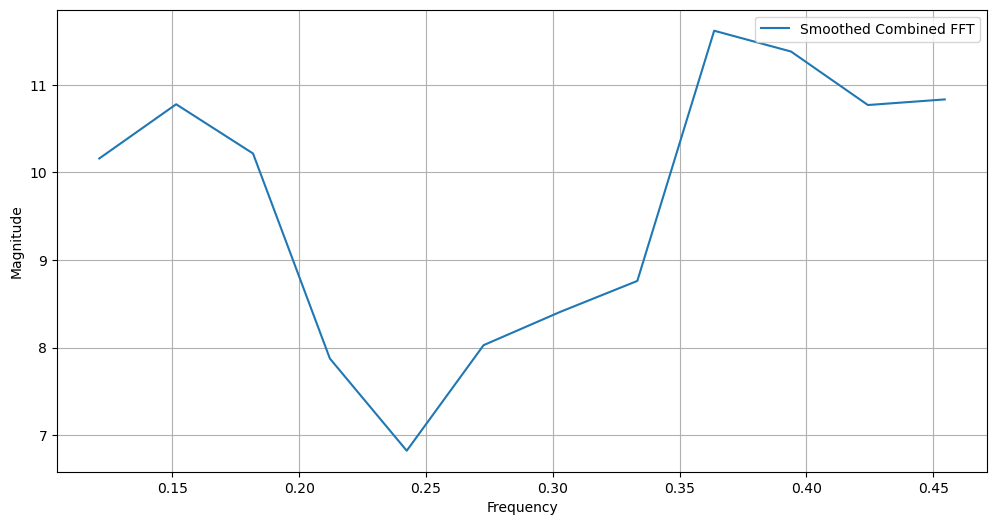

In [15]:
from scipy.fft import fft

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

x_shift_all = []

for p in tp_trajectories_final.particle.unique():
    x_shift_data = tp_trajectories_final.query('particle==@p')['x_shift'].values
    x_shift_all.extend(x_shift_data)  

x_shift_all = np.array(x_shift_all)

fft_result = fft(x_shift_all)

n = len(x_shift_all)
freq = np.fft.fftfreq(n)

fft_magnitude = np.abs(fft_result)
smoothed_magnitude = moving_average(fft_magnitude, window_size=5)  

smoothed_freq = freq[:n // 2][4:]

plt.figure(figsize=(12, 6))
plt.plot(smoothed_freq, smoothed_magnitude[:len(smoothed_freq)], label='Smoothed Combined FFT')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()


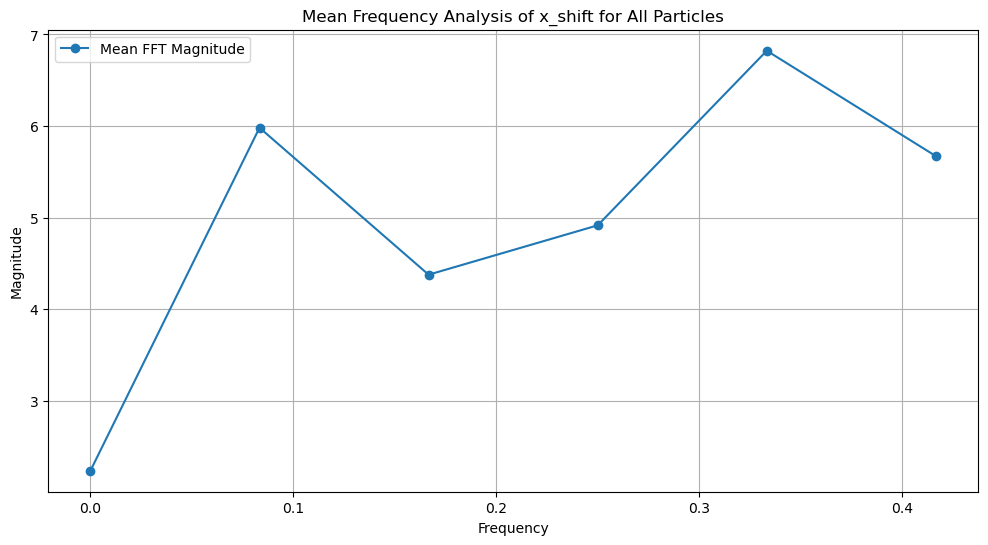

In [16]:
from scipy.fft import fft

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))

# Initialize a list to accumulate FFT magnitudes for averaging
all_magnitudes = []
frequencies = []

# Set the window size for moving average
window_size = 1

for p in tp_trajectories_final.particle.unique():
    x_shift_data = tp_trajectories_final.query('particle==@p')['x_shift'].values
    
    if len(x_shift_data) > 0:  # Ensure there's data to process
        fft_result = fft(x_shift_data)
        
        n = len(x_shift_data)
        freq = np.fft.fftfreq(n)
        
        fft_magnitude = np.abs(fft_result)
        smoothed_magnitude = moving_average(fft_magnitude, window_size=window_size)
        
        smoothed_freq = freq[:n // 2][4:]

        # Append the smoothed magnitude to the list
        all_magnitudes.append(smoothed_magnitude)

# If all_magnitudes is not empty, proceed to compute the mean
if all_magnitudes:
    # Find the maximum length of the magnitudes
    max_length = max(len(mag) for mag in all_magnitudes)
    
    # Pad each magnitude with zeros to make them all the same length
    padded_magnitudes = [np.pad(mag, (0, max_length - len(mag)), 'constant') for mag in all_magnitudes]

    # Calculate the mean magnitude across all particles
    mean_magnitude = np.mean(padded_magnitudes, axis=0)

    # Use the frequency corresponding to the maximum length for plotting
    # Generate frequency values corresponding to the maximum length
    mean_freq = np.fft.fftfreq(max_length)[:max_length // 2]

    plt.plot(mean_freq, mean_magnitude[:len(mean_freq)], '-o', label='Mean FFT Magnitude')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.title('Mean Frequency Analysis of x_shift for All Particles')
    plt.show()
else:
    print("No valid x_shift data available for any particles.")


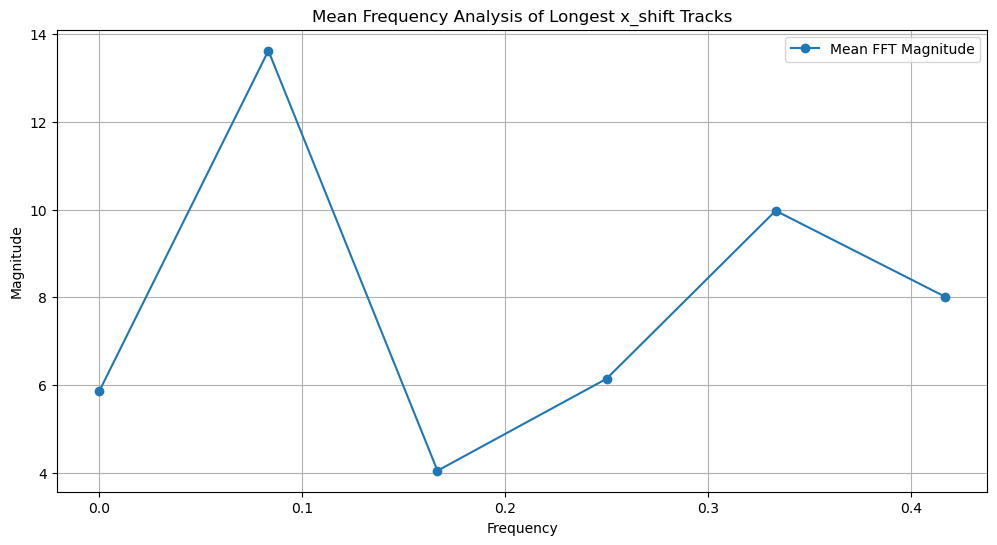

In [1241]:
from scipy.fft import fft

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))

# Initialize a list to accumulate FFT magnitudes for averaging
all_magnitudes = []

# Set the window size for moving average
window_size =1

# Iterate through each unique particle
for p in tp_trajectories_final.particle.unique():
    # Extract all x_shift data for the current particle
    x_shift_data = tp_trajectories_final.query('particle==@p')['x_shift'].values
    
    if len(x_shift_data) > 0:  # Ensure there's data to process
        # Store the length of the current track
        current_length = len(x_shift_data)
        
        # Check if this is the longest track seen so far
        if len(all_magnitudes) == 0 or current_length > len(all_magnitudes[-1]):
            # Perform FFT on the longest track
            fft_result = fft(x_shift_data)
            
            n = len(x_shift_data)
            fft_magnitude = np.abs(fft_result)
            smoothed_magnitude = moving_average(fft_magnitude, window_size=window_size)
            
            # Append the smoothed magnitude to the list
            all_magnitudes.append(smoothed_magnitude)

# If all_magnitudes is not empty, proceed to compute the mean
if all_magnitudes:
    # Find the maximum length of the magnitudes
    max_length = max(len(mag) for mag in all_magnitudes)
    
    # Pad each magnitude with zeros to make them all the same length
    padded_magnitudes = [np.pad(mag, (0, max_length - len(mag)), 'constant') for mag in all_magnitudes]

    # Calculate the mean magnitude across all particles
    mean_magnitude = np.mean(padded_magnitudes, axis=0)

    # Use the frequency corresponding to the maximum length for plotting
    # Generate frequency values corresponding to the maximum length
    mean_freq = np.fft.fftfreq(max_length)[:max_length // 2]

    plt.plot(mean_freq, mean_magnitude[:len(mean_freq)],'-o', label='Mean FFT Magnitude')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()
    plt.title('Mean Frequency Analysis of Longest x_shift Tracks')
    plt.show()
else:
    print("No valid x_shift data available for any particles.")


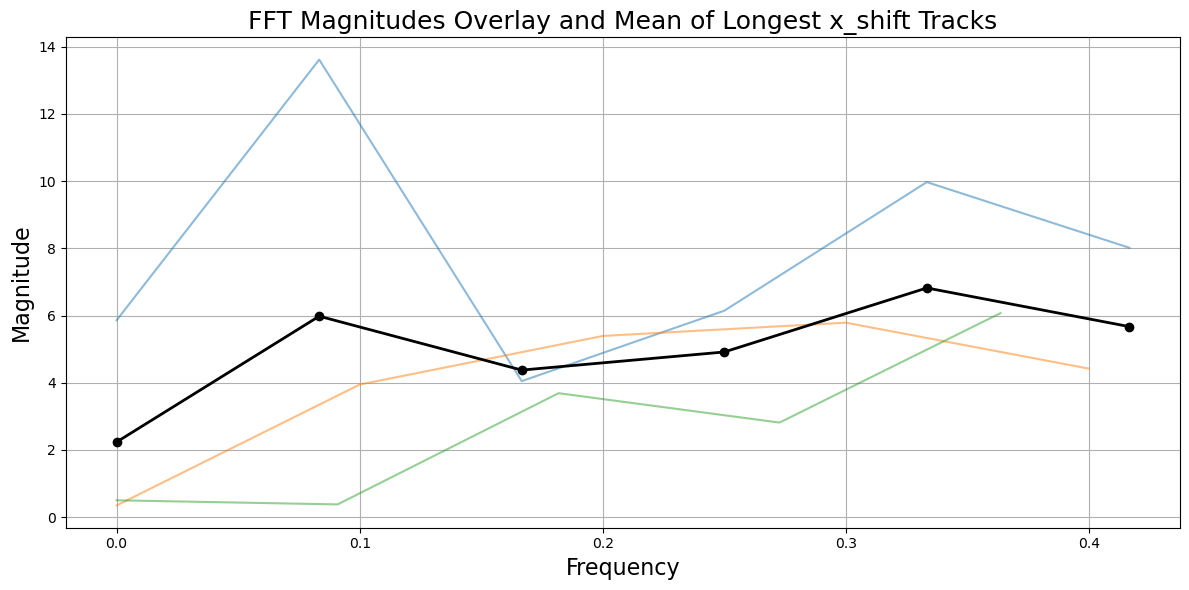

Particle 517: Max Frequency = 0.08333333333333333
Particle 1661: Max Frequency = 0.30000000000000004
Particle 1746: Max Frequency = 0.36363636363636365


In [17]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 6))

# Initialize a list to accumulate FFT magnitudes for averaging
all_magnitudes = []
max_frequencies = []  # List to store the maximum frequency for each curve

# Set the window size for moving average
window_size = 1

# Iterate through each unique particle
for p in tp_trajectories_final.particle.unique():
    # Extract all x_shift data for the current particle
    x_shift_data = tp_trajectories_final.query('particle==@p')['x_shift'].values
    
    if len(x_shift_data) > 0:  # Ensure there's data to process
        # Perform FFT on the current track
        fft_result = fft(x_shift_data)
        
        # Calculate the FFT magnitude
        fft_magnitude = np.abs(fft_result)
        smoothed_magnitude = moving_average(fft_magnitude, window_size=window_size)
        
        # Append the smoothed magnitude to the list
        all_magnitudes.append(smoothed_magnitude)
        
        # Calculate the frequency corresponding to the current particle's data
        n = len(x_shift_data)
        freq = np.fft.fftfreq(n)[:n // 2]  # Generate frequency values
        
        # Plot each particle's FFT magnitude
        plt.plot(freq, smoothed_magnitude[:len(freq)], alpha=0.5, label=f'Particle {p}')  # Overlay with transparency
        
        # Store the maximum frequency for the current particle
        max_frequency = freq[np.argmax(smoothed_magnitude[:len(freq)])]  # Find max frequency
        max_frequencies.append((p, max_frequency))  # Store particle ID and max frequency

# If all_magnitudes is not empty, compute the mean
if all_magnitudes:
    # Find the maximum length of the magnitudes
    max_length = max(len(mag) for mag in all_magnitudes)
    
    # Pad each magnitude with zeros to make them all the same length
    padded_magnitudes = [np.pad(mag, (0, max_length - len(mag)), 'constant') for mag in all_magnitudes]

    # Calculate the mean magnitude across all particles
    mean_magnitude = np.mean(padded_magnitudes, axis=0)

    # Generate frequency values corresponding to the maximum length
    mean_freq = np.fft.fftfreq(max_length)[:max_length // 2]

    # Plot the mean magnitude
    plt.plot(mean_freq, mean_magnitude[:len(mean_freq)], '-o', color='black', label='Mean FFT Magnitude', linewidth=2)
    
    # Customize the plot
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude', fontsize=16)
    plt.title('FFT Magnitudes Overlay and Mean of Longest x_shift Tracks', fontsize=18)
    plt.grid()
    # plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid x_shift data available for any particles.")

# Print the maximum frequencies for each particle
for particle, max_freq in max_frequencies:
    print(f'Particle {particle}: Max Frequency = {max_freq}')


## Plotting the distributions
### Track duration distribution (s)

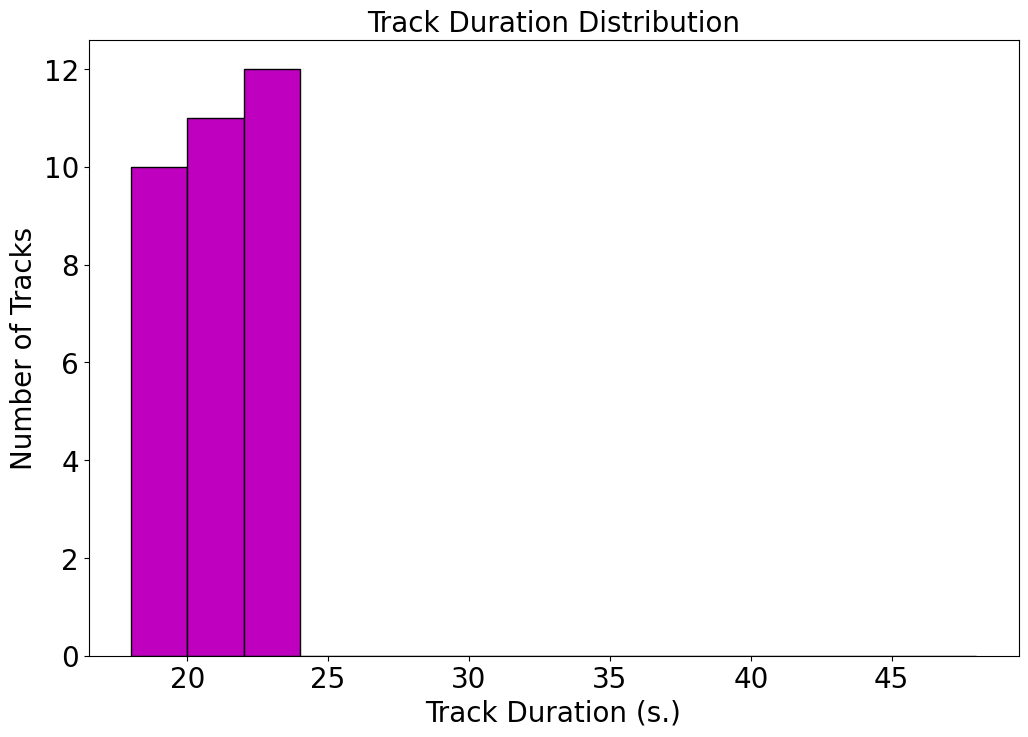

In [18]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['track_duration']*frame_interval, bins=np.arange(19,51,2), color='m', edgecolor='k', align='left')
plt.title('Track Duration Distribution', fontsize=20)
plt.xlabel('Track Duration (s.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\track_durations.svg', format='svg', bbox_inches='tight')


In [19]:
tp_trajectories_final['track_duration']*frame_interval

0     24.01644
1     24.01644
2     24.01644
3     24.01644
4     24.01644
5     24.01644
6     24.01644
7     24.01644
8     24.01644
9     24.01644
10    24.01644
11    24.01644
12    20.01370
13    20.01370
14    20.01370
15    20.01370
16    20.01370
17    22.01507
18    22.01507
19    20.01370
20    22.01507
21    20.01370
22    20.01370
23    22.01507
24    20.01370
25    20.01370
26    22.01507
27    22.01507
28    22.01507
29    22.01507
30    22.01507
31    22.01507
32    22.01507
Name: track_duration, dtype: float64

C:\Users\spandanp\AppData\Local\Temp\ipykernel_14700\800274701.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\spandanp\AppData\Local\Temp\ipykernel_14700\800274701.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_exp, pcov_exp = curve_fit(exponential_decay, bin_centers[counts > 0], normalized_counts[counts > 0], maxfev=10000)


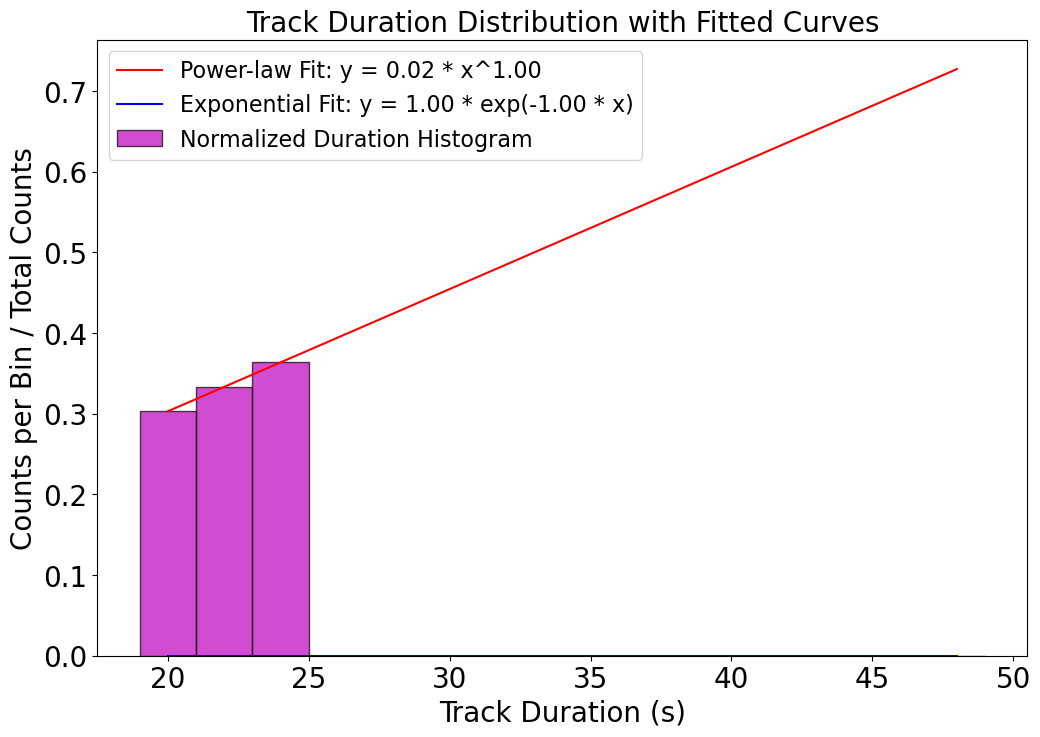

Power-law fit results:
a = 0.0152 ± 0.0000
k = 1.0000 ± 0.0000
R² = -13.5349

Exponential fit results:
a = 1.0000 ± inf
b = 1.0000 ± inf
R² = -0.2483



In [33]:
def power_law(x, a, k):
    return a * np.power(x, k)

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Calculate histogram (raw counts) for track duration
counts, bin_edges = np.histogram(tp_trajectories_final['track_duration'] * frame_interval, 
                                   bins=np.arange(19, 51, 2), 
                                   density=False)  # Density False for raw counts

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Normalize counts by total counts
total_counts = sum(counts)
normalized_counts = counts / total_counts if total_counts > 0 else counts  # Avoid division by zero

# Fit the power-law and exponential decay to the histogram data
try:
    # Fit the power-law (use only non-zero counts for fitting)
    popt_power, pcov_power = curve_fit(power_law, bin_centers[counts > 0], normalized_counts[counts > 0], maxfev=10000)
    perr_power = np.sqrt(np.diag(pcov_power))  # Standard deviation errors

    # Calculate R^2 for power-law fit
    power_pred = power_law(bin_centers, *popt_power)
    ss_res_power = np.sum((normalized_counts - power_pred) ** 2)
    ss_tot_power = np.sum((normalized_counts - np.mean(normalized_counts)) ** 2)
    r2_power = 1 - (ss_res_power / ss_tot_power)

    # Fit the exponential decay (use only non-zero counts for fitting)
    popt_exp, pcov_exp = curve_fit(exponential_decay, bin_centers[counts > 0], normalized_counts[counts > 0], maxfev=10000)
    perr_exp = np.sqrt(np.diag(pcov_exp))  # Standard deviation errors

    # Calculate R^2 for exponential fit
    exp_pred = exponential_decay(bin_centers, *popt_exp)
    ss_res_exp = np.sum((normalized_counts - exp_pred) ** 2)
    ss_tot_exp = np.sum((normalized_counts - np.mean(normalized_counts)) ** 2)
    r2_exp = 1 - (ss_res_exp / ss_tot_exp)

except RuntimeError as e:
    print(f"Error fitting curves: {e}")

# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize=(12, 8))

# Plot normalized histogram
ax.bar(bin_centers, normalized_counts, width=np.diff(bin_edges), color='m', edgecolor='k', alpha=0.7, label='Normalized Duration Histogram')

# Plot fitted power-law curve
ax.plot(bin_centers, power_law(bin_centers, *popt_power), color='red', label=f'Power-law Fit: y = {popt_power[0]:.2f} * x^{popt_power[1]:.2f}')

# Plot fitted exponential curve
ax.plot(bin_centers, exponential_decay(bin_centers, *popt_exp), color='blue', label=f'Exponential Fit: y = {popt_exp[0]:.2f} * exp(-{popt_exp[1]:.2f} * x)')

# Customize plot
ax.set_title('Track Duration Distribution with Fitted Curves', fontsize=20)
ax.set_xlabel('Track Duration (s)', fontsize=20)
ax.set_ylabel('Counts per Bin / Total Counts', fontsize=20)  # Update y-label
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid(False)
ax.legend(fontsize=16)

# Show plot
plt.show()

# Print fit results and R^2 values
print("Power-law fit results:")
print(f"a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")
print(f"k = {popt_power[1]:.4f} ± {perr_power[1]:.4f}")
print(f"R² = {r2_power:.4f}\n")

print("Exponential fit results:")
print(f"a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
print(f"b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")
print(f"R² = {r2_exp:.4f}\n")


### Track angles distribution

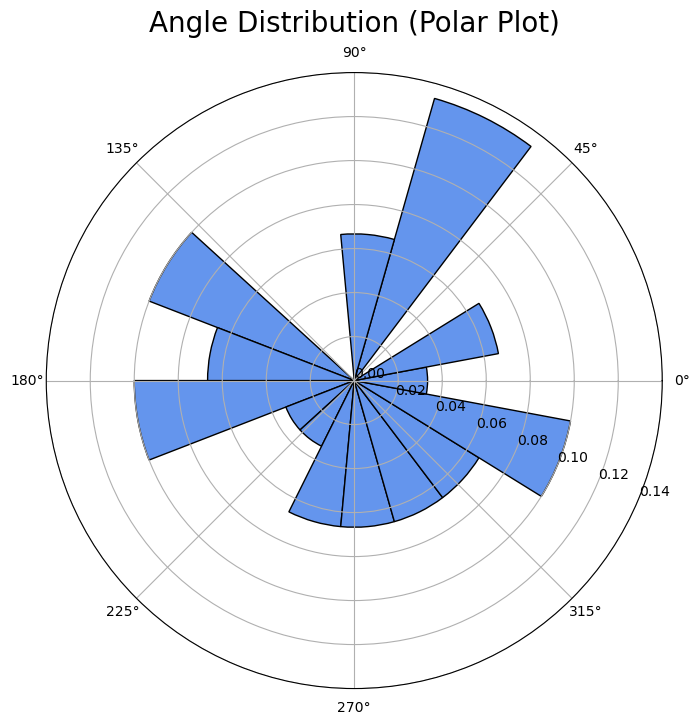

In [23]:
# Assuming 'tp_trajectories_final' contains the angle in radians
angles = tp_trajectories_final['angle'].dropna()  # Use angles directly in radians

# Create a histogram for angle distribution (angles in radians) from -π to π
bins = np.linspace(-np.pi, np.pi, 18)  # Create bins from -π to π
hist, _ = np.histogram(angles, bins=bins)  # Histogram in radians

# Calculate the midpoint of the bins for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Normalize the histogram for radial representation
r = hist / np.sum(hist)  # Normalize to a range of [0, 1]

# Create a polar plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'polar'})
ax.bar(bin_centers, r, width=np.diff(bins), bottom=0, color='cornflowerblue', edgecolor='k')

# Calculate the maximum value for r and set rmax
rmax = np.max(r)
ax.set_rmax(rmax)  # Set maximum radial limit

# Dynamically create radial ticks based on rmax
# Example: Create ticks at 0.2 increments
rtick_values = np.arange(0, rmax + 0.02, 0.02)  # Adjust this step size as needed
ax.set_rticks(rtick_values)  # Set radial ticks

ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted bars
ax.grid(True)

# Set the title
ax.set_title('Angle Distribution (Polar Plot)', va='bottom', fontsize=20)

# Show the plot
plt.show()

# Optional: Save as SVG with highest resolution
# fig.savefig(data_folder + '\\angle_distribution_polar.svg', format='svg', bbox_inches='tight')


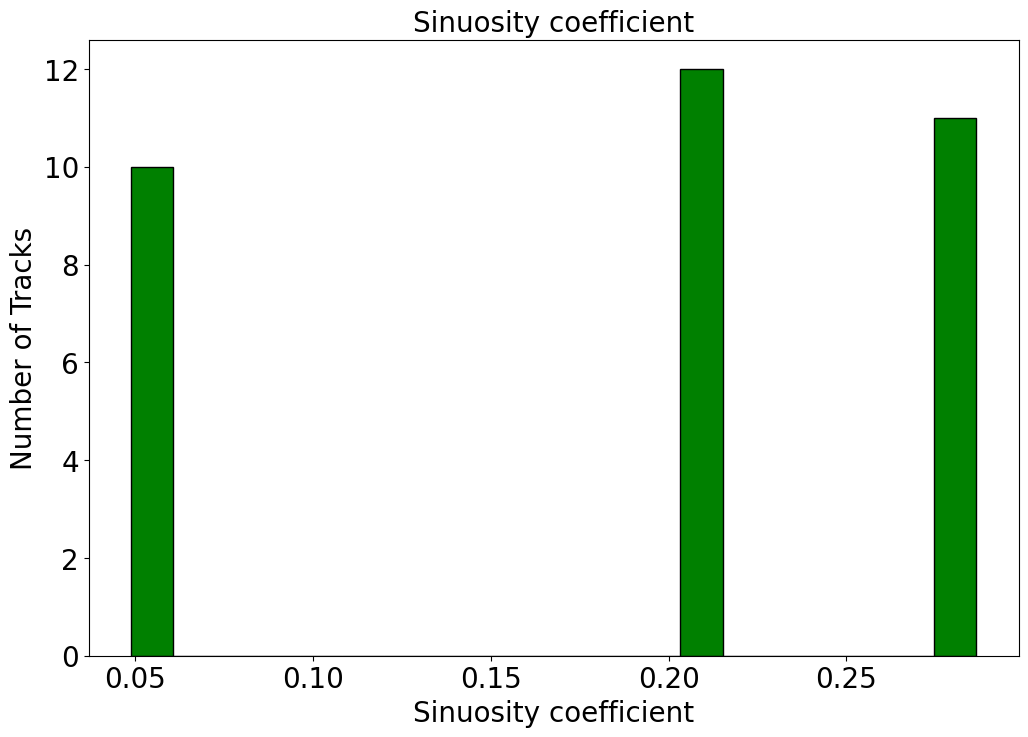

In [22]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['distance']/tp_trajectories_final['track_length'], bins=20, color='g', edgecolor='k', align='left')
plt.title('Sinuosity coefficient', fontsize=20)
plt.xlabel('Sinuosity coefficient', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()


In [24]:
tp_trajectories_final['distance']/tp_trajectories_final['track_length']

0     0.216700
1     0.216700
2     0.216700
3     0.216700
4     0.216700
5     0.216700
6     0.216700
7     0.216700
8     0.216700
9     0.216700
10    0.216700
11    0.216700
12    0.054639
13    0.054639
14    0.054639
15    0.054639
16    0.054639
17    0.292490
18    0.292490
19    0.054639
20    0.292490
21    0.054639
22    0.054639
23    0.292490
24    0.054639
25    0.054639
26    0.292490
27    0.292490
28    0.292490
29    0.292490
30    0.292490
31    0.292490
32    0.292490
dtype: float64

In [25]:
tp_trajectories_final['track_length']/tp_trajectories_final['distance']

0      4.614679
1      4.614679
2      4.614679
3      4.614679
4      4.614679
5      4.614679
6      4.614679
7      4.614679
8      4.614679
9      4.614679
10     4.614679
11     4.614679
12    18.302013
13    18.302013
14    18.302013
15    18.302013
16    18.302013
17     3.418924
18     3.418924
19    18.302013
20     3.418924
21    18.302013
22    18.302013
23     3.418924
24    18.302013
25    18.302013
26     3.418924
27     3.418924
28     3.418924
29     3.418924
30     3.418924
31     3.418924
32     3.418924
dtype: float64

### Track total distance traversed distribution (um.)

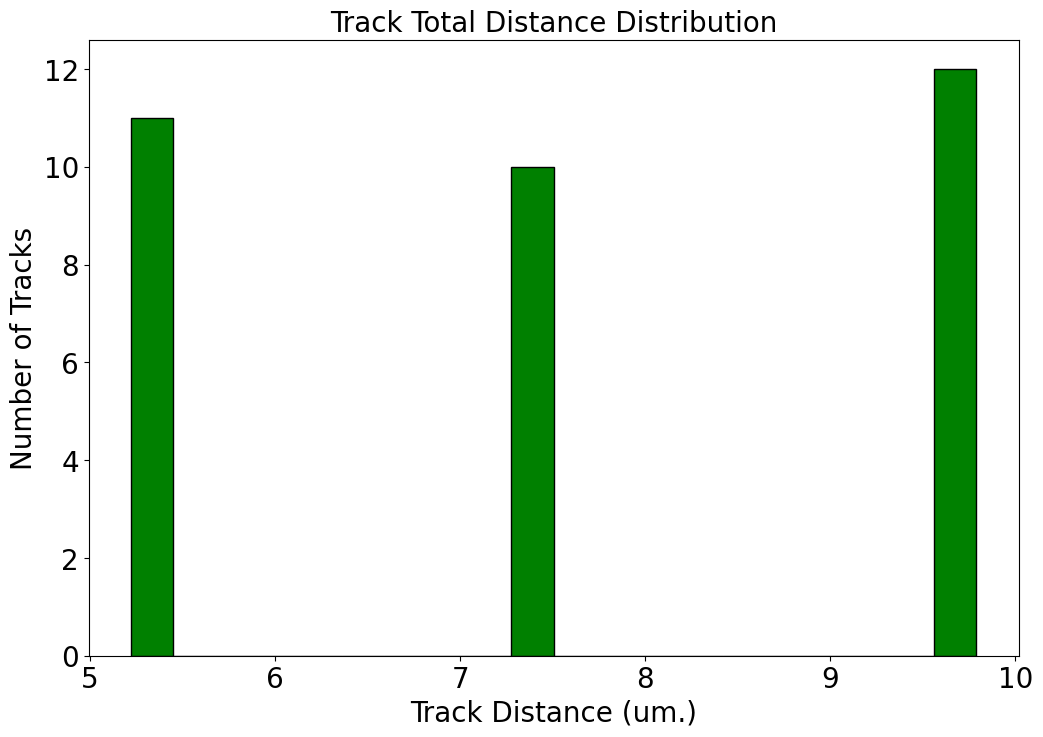

In [26]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final['track_length']/resolution, bins=20, color='g', edgecolor='k', align='left')
plt.title('Track Total Distance Distribution', fontsize=20)
plt.xlabel('Track Distance (um.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\track_total_distance.svg', format='svg', bbox_inches='tight')

In [27]:
tp_trajectories_final['track_length']/resolution

0     9.902476
1     9.902476
2     9.902476
3     9.902476
4     9.902476
5     9.902476
6     9.902476
7     9.902476
8     9.902476
9     9.902476
10    9.902476
11    9.902476
12    7.589256
13    7.589256
14    7.589256
15    7.589256
16    7.589256
17    5.334668
18    5.334668
19    7.589256
20    5.334668
21    7.589256
22    7.589256
23    5.334668
24    7.589256
25    7.589256
26    5.334668
27    5.334668
28    5.334668
29    5.334668
30    5.334668
31    5.334668
32    5.334668
Name: track_length, dtype: float64

### Track final position distance distribution (um.)

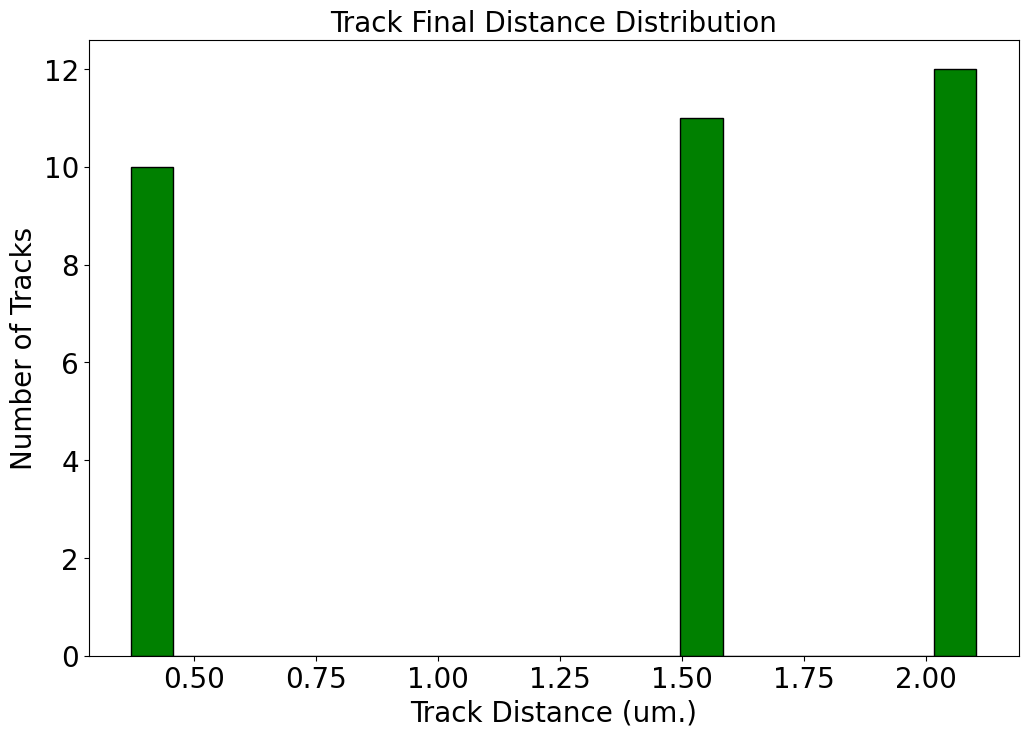

In [28]:
# Plot Track Duration Distribution
fig, ax = plt.subplots(figsize = (12,8))

plt.hist(tp_trajectories_final[
         'distance']/resolution, bins=20, color='g', edgecolor='k', align='left')
plt.title('Track Final Distance Distribution', fontsize=20)
plt.xlabel('Track Distance (um.)', fontsize=20)
plt.ylabel('Number of Tracks', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.grid(False)
plt.show()
# Save as SVG with highest resolution
# fig.savefig(data_folder+'\\    .svg', format='svg', bbox_inches='tight')

In [29]:
tp_trajectories_final['distance']/resolution

0     2.145864
1     2.145864
2     2.145864
3     2.145864
4     2.145864
5     2.145864
6     2.145864
7     2.145864
8     2.145864
9     2.145864
10    2.145864
11    2.145864
12    0.414668
13    0.414668
14    0.414668
15    0.414668
16    0.414668
17    1.560335
18    1.560335
19    0.414668
20    1.560335
21    0.414668
22    0.414668
23    1.560335
24    0.414668
25    0.414668
26    1.560335
27    1.560335
28    1.560335
29    1.560335
30    1.560335
31    1.560335
32    1.560335
Name: distance, dtype: float64

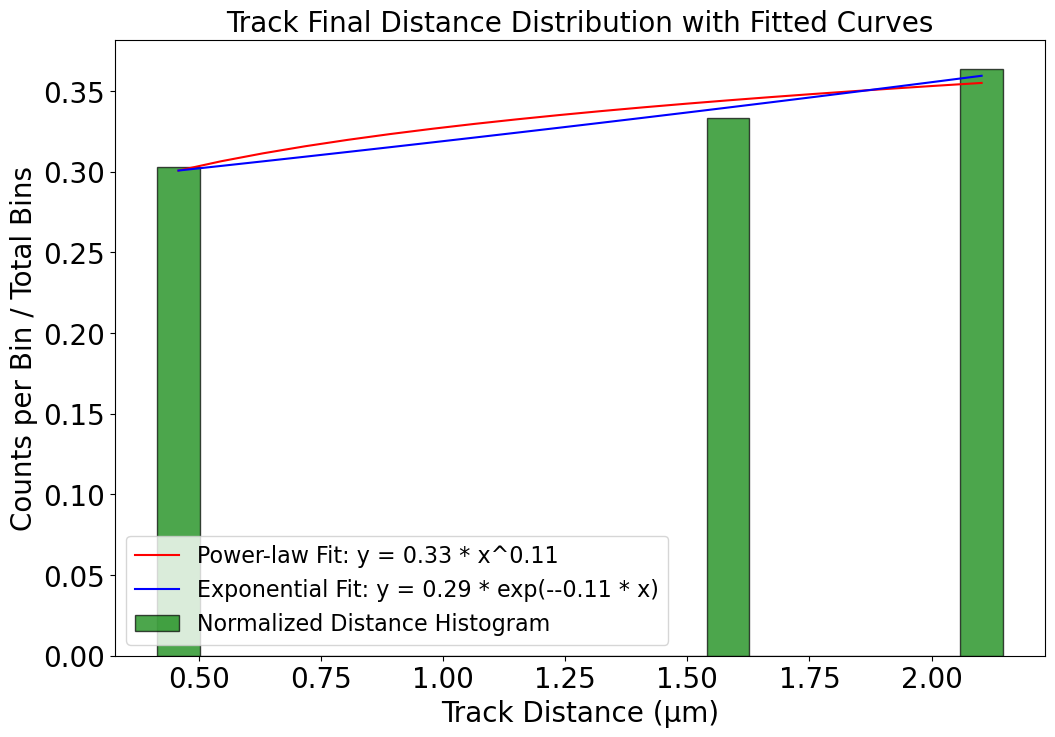

Power-law fit results:
a = 0.3274 ± 0.0085
k = 0.1090 ± 0.0388
R² = -5.6432

Exponential fit results:
a = 0.2862 ± 0.0097
b = -0.1085 ± 0.0210
R² = -5.4514



In [34]:
# Calculate histogram (raw counts)
counts, bin_edges = np.histogram(tp_trajectories_final['distance'] / resolution, bins=20)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

normalized_counts = counts / sum(counts)

# Fit the power-law and exponential decay to the histogram data
try:
    # Fit the power-law (use only non-zero counts for fitting)
    popt_power, pcov_power = curve_fit(power_law, bin_centers[counts > 0], normalized_counts[counts > 0], maxfev=10000)
    perr_power = np.sqrt(np.diag(pcov_power))  # Standard deviation errors

    # Calculate R^2 for power-law fit
    power_pred = power_law(bin_centers, *popt_power)
    ss_res_power = np.sum((normalized_counts - power_pred) ** 2)
    ss_tot_power = np.sum((normalized_counts - np.mean(normalized_counts)) ** 2)
    r2_power = 1 - (ss_res_power / ss_tot_power)

    # Fit the exponential decay (use only non-zero counts for fitting)
    popt_exp, pcov_exp = curve_fit(exponential_decay, bin_centers[counts > 0], normalized_counts[counts > 0], maxfev=10000)
    perr_exp = np.sqrt(np.diag(pcov_exp))  # Standard deviation errors

    # Calculate R^2 for exponential fit
    exp_pred = exponential_decay(bin_centers, *popt_exp)
    ss_res_exp = np.sum((normalized_counts - exp_pred) ** 2)
    ss_tot_exp = np.sum((normalized_counts - np.mean(normalized_counts)) ** 2)
    r2_exp = 1 - (ss_res_exp / ss_tot_exp)

except RuntimeError as e:
    print(f"Error fitting curves: {e}")

# Plot Track Final Distance Distribution
fig, ax = plt.subplots(figsize=(12, 8))

# Plot normalized histogram
ax.bar(bin_centers, normalized_counts, width=np.diff(bin_edges), color='g', edgecolor='k', alpha=0.7, label='Normalized Distance Histogram')

# Plot fitted power-law curve
ax.plot(bin_centers, power_law(bin_centers, *popt_power), color='red', label=f'Power-law Fit: y = {popt_power[0]:.2f} * x^{popt_power[1]:.2f}')

# Plot fitted exponential curve
ax.plot(bin_centers, exponential_decay(bin_centers, *popt_exp), color='blue', label=f'Exponential Fit: y = {popt_exp[0]:.2f} * exp(-{popt_exp[1]:.2f} * x)')

# Customize plot
ax.set_title('Track Final Distance Distribution with Fitted Curves', fontsize=20)
ax.set_xlabel('Track Distance (µm)', fontsize=20)
ax.set_ylabel('Counts per Bin / Total Bins', fontsize=20)  # Update y-label
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid(False)
ax.legend(fontsize=16)

# Show plot
plt.show()

# Print fit results and R^2 values
print("Power-law fit results:")
print(f"a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")
print(f"k = {popt_power[1]:.4f} ± {perr_power[1]:.4f}")
print(f"R² = {r2_power:.4f}\n")

print("Exponential fit results:")
print(f"a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
print(f"b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")
print(f"R² = {r2_exp:.4f}\n")


In [1181]:
counts/sum(counts)

array([0.23076923, 0.18856838, 0.09882479, 0.08707265, 0.09294872,
       0.06517094, 0.05608974, 0.06837607, 0.03418803, 0.02457265,
       0.00961538, 0.01014957, 0.        , 0.00534188, 0.        ,
       0.01014957, 0.        , 0.        , 0.01068376, 0.00747863])

### Track velocities distribution (#um./min)

KeyError: 'avg_velocity'

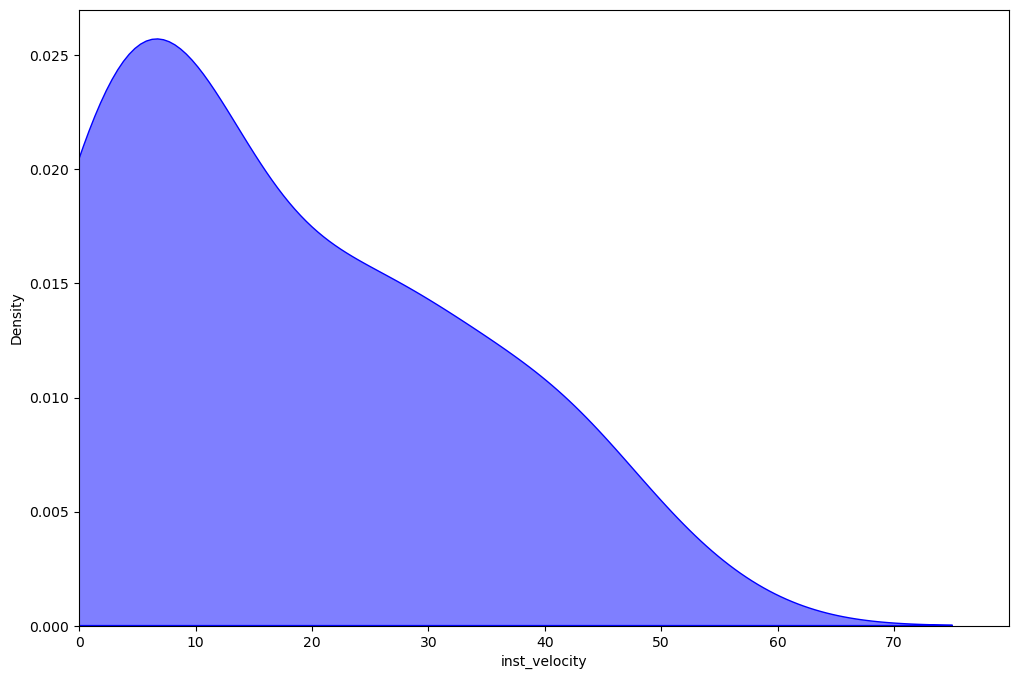

In [44]:
# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot average instantaneous velocity distribution
sns.kdeplot(tp_trajectories_final['inst_velocity'] * 60 / (resolution * frame_interval),
            label='Instantaneous Velocity (avg.)', color='blue', fill=True, alpha=0.5).set(xlim=(0))

# Plot for overall average velocities
sns.kdeplot(tp_trajectories_final['avg_velocity'] * 60 / (resolution * frame_interval),
            label='Average Velocity', color='green', fill=True, alpha=0.5).set(xlim=(0))

# Add vertical lines for medians
plt.axvline(np.median(tp_trajectories_final['inst_velocity']) * 60 / (resolution * frame_interval),
            color='blue', linestyle='--', label='Median Instantaneous Velocity (for all tracks)')
plt.axvline(np.median(tp_trajectories_final['avg_velocity']) * 60 / (resolution * frame_interval),
            color='green', linestyle='--', label='Median Average Velocity (for all tracks)')

# Set x-axis limits and labels
plt.xlim(0, )  # Only set x limit
plt.xlabel('Velocity (μm/min)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.title('Distribution of Average and Overall Instantaneous Velocities', fontsize=20)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)

# Add legend
plt.legend(fontsize=15)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save the figure
# fig.savefig(os.path.join(data_folder, 'track_velocities.svg'), format='svg', bbox_inches='tight')


In [43]:
print(f'Number of unique tracks: {num_particles:.2f}')
tp_trajectories_final

Number of unique tracks: 3.00


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,x_shift,y_shift,frame_shift,displacement,inst_velocity
frame,,,,,,,,,,,,,,,
33,372.073779,281.081755,14.547949,1.336653,0.356993,2.117648,112.936351,0.000308,33,517,0.000000,0.000000,1.0,0.000000,0.000000
34,373.077970,282.899752,11.458245,1.343300,0.424321,1.375557,74.481553,0.000510,34,517,1.817998,1.004192,1.0,2.076901,2.076901
35,372.705435,283.798913,10.082492,1.329433,0.166577,1.249352,68.271497,0.000403,35,517,0.899161,-0.372536,1.0,0.973279,0.973279
36,372.095725,282.896840,13.446337,1.302700,0.255292,1.637054,81.122923,0.000794,36,517,-0.902073,-0.609710,1.0,1.088798,1.088798
38,372.840336,284.987395,2.478527,1.214409,0.251156,0.406145,16.552629,0.001934,38,517,2.090555,0.744611,2.0,2.219204,1.109602
39,371.210101,288.672727,4.428061,1.180652,0.566121,0.894558,28.894423,0.001110,39,517,3.685332,-1.630235,1.0,4.029807,4.029807
40,369.428436,286.187678,13.728844,1.294538,0.210257,2.030047,92.077501,0.000326,40,517,-2.485050,-1.781665,1.0,3.057744,3.057744
41,369.186147,286.366883,8.152969,1.263456,0.339867,1.279416,48.872234,0.000601,41,517,0.179205,-0.242289,1.0,0.301361,0.301361
42,372.766092,284.999093,11.506928,1.230100,0.069400,1.856966,73.344283,0.000354,42,517,-1.367790,3.579945,1.0,3.832344,3.832344


In [932]:
# Save DataFrame to CSV
save_path = data_folder+'\\'
tp_trajectories_final.to_csv(save_path+'tp_trajectories_final.csv', index=False)


### What's the 1px/frame speed equivalent in #um./min

In [1149]:
0.5*60/(resolution*frame_interval)

5.396260361997628

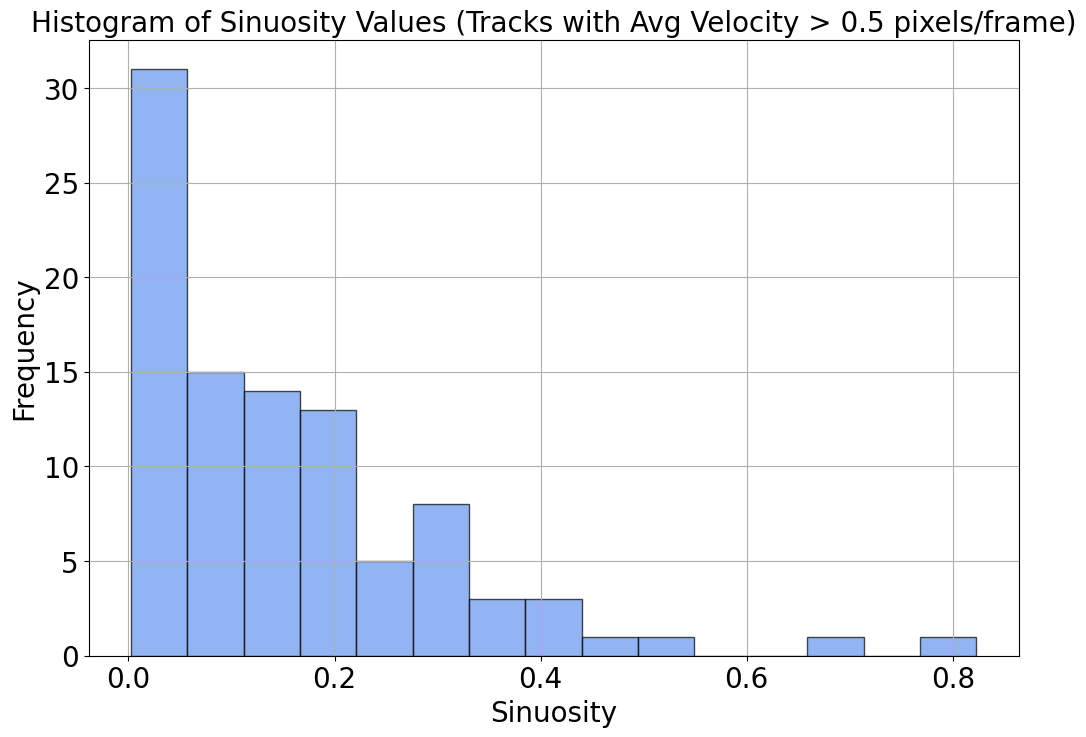

In [1194]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# Filter for tracks with avg_inst_velocity > 0.5 pixels/frame and track_duration > 10 frames
filtered_tracks = tp_trajectories_final.groupby('particle').filter(
    lambda group: group['track_duration'].iloc[0] > 10 and group['avg_inst_velocity'].iloc[0] > 0.5
)

# List to store sinuosity results
sinuosity_results = []

# Loop through each particle (track)
for particle_id, group in filtered_tracks.groupby('particle'):
    # Extract necessary variables for sinuosity calculation
    track_length = group['track_length'].iloc[0]
    x_start = group['x_start'].iloc[0]
    y_start = group['y_start'].iloc[0]
    x_end = group['x_end'].iloc[0]
    y_end = group['y_end'].iloc[0]

    # Calculate straight-line distance
    straight_distance = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)

    # Calculate sinuosity
    sinuosity = straight_distance / track_length if straight_distance != 0 else np.nan

    # Append results
    sinuosity_results.append(sinuosity)

# Filter out NaN values from sinuosity results
sinuosity_results = np.array([s for s in sinuosity_results if not np.isnan(s)])

# Plotting a histogram of sinuosity values
if len(sinuosity_results) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(sinuosity_results, bins=15, color='cornflowerblue', stacked = 'True', edgecolor='k', alpha=0.7)

    # Set title and labels with correct functions
    ax.set_title('Histogram of Sinuosity Values (Tracks with Avg Velocity > 0.5 pixels/frame)', fontsize=20)
    ax.set_xlabel('Sinuosity', fontsize=20)
    ax.set_ylabel('Frequency', fontsize=20)

    # Additional plot formatting
    plt.grid(True)
    # plt.axvline(1, color='k', linestyle='--', linewidth=1, label='Sinuosity = 1')  # Reference line for sinuosity = 1
    # plt.legend()

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Show plot
    plt.show()
else:
    print("No tracks with the given criteria.")


Power-law fit results:
a = 541.8923 ± 40.1337
k = -1.3596 ± 0.0388

Exponential fit results:
a = 95.3217 ± 5.1747
b = 0.1126 ± 0.0068


C:\Users\spandanp\AppData\Local\Temp\ipykernel_32864\2689438684.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


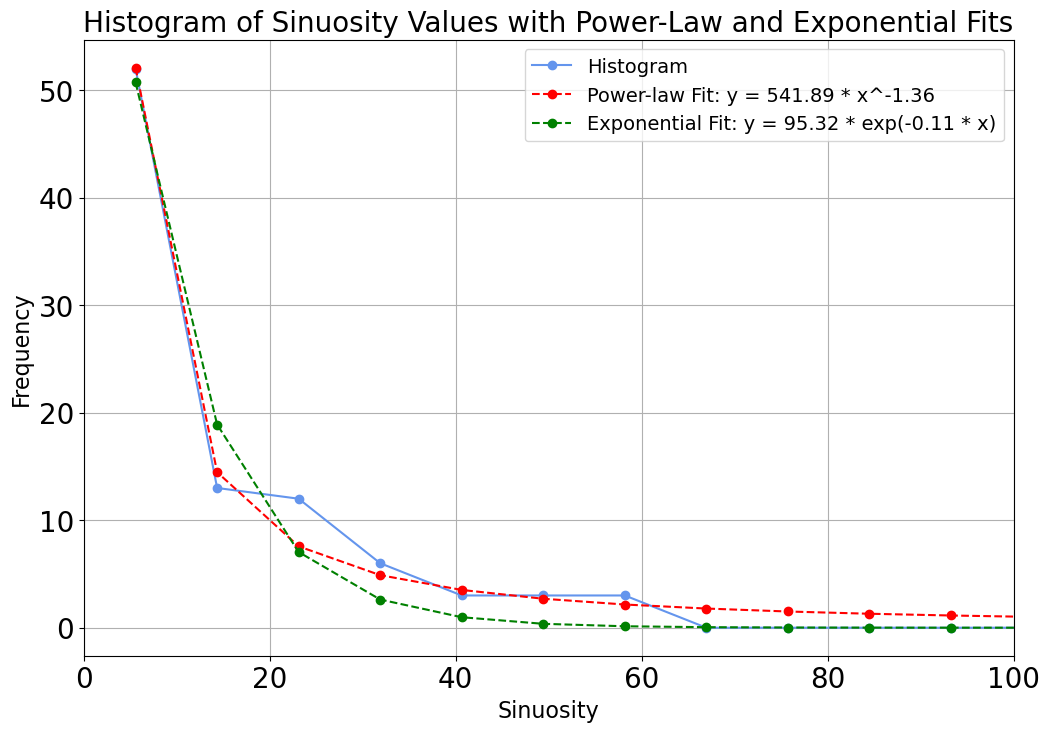

R-squared for Power-law fit: 0.9861
R-squared for Exponential fit: 0.9670


In [1213]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Function for power-law: y = a * x^k
def power_law(x, a, k):
    return a * np.power(x, k)

# Function for exponential decay: y = a * exp(-b * x)
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# R-squared calculation function
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Filter for tracks with avg_inst_velocity > 0.5 pixels/frame and track_duration > 10 frames
filtered_tracks = tp_trajectories_final.groupby('particle').filter(
    lambda group: group['track_duration'].iloc[0] > 10 and group['avg_inst_velocity'].iloc[0] > 0.5
)

# List to store sinuosity results
sinuosity_results = []

# Loop through each particle (track)
for particle_id, group in filtered_tracks.groupby('particle'):
    track_length = group['track_length'].iloc[0]
    x_start = group['x_start'].iloc[0]
    y_start = group['y_start'].iloc[0]
    x_end = group['x_end'].iloc[0]
    y_end = group['y_end'].iloc[0]
    
    straight_distance = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
    sinuosity = track_length / straight_distance if straight_distance != 0 else np.nan
    sinuosity_results.append(sinuosity)

# Remove NaN values
sinuosity_results = np.array([s for s in sinuosity_results if not np.isnan(s)])

# Plotting the histogram of sinuosity values
if len(sinuosity_results) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate histogram (normalized)
    counts, bin_edges = np.histogram(sinuosity_results, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram as a line plot
    ax.plot(bin_centers, counts, '-o', color='cornflowerblue', label='Histogram')

    # Fit the power-law
    popt_power, pcov_power = curve_fit(power_law, bin_centers, counts, maxfev=10000)
    perr_power = np.sqrt(np.diag(pcov_power))  # Standard deviation errors

    # Fit the exponential decay
    popt_exp, pcov_exp = curve_fit(exponential_decay, bin_centers, counts, maxfev=10000)
    perr_exp = np.sqrt(np.diag(pcov_exp))  # Standard deviation errors

    # Plot the fits
    ax.plot(bin_centers, power_law(bin_centers, *popt_power), '--o', color='red', label=f'Power-law Fit: y = {popt_power[0]:.2f} * x^{popt_power[1]:.2f}')
    ax.plot(bin_centers, exponential_decay(bin_centers, *popt_exp), '--o', color='green', label=f'Exponential Fit: y = {popt_exp[0]:.2f} * exp(-{popt_exp[1]:.2f} * x)')

    # Print the fit parameters and their errors
    print("Power-law fit results:")
    print(f"a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")
    print(f"k = {popt_power[1]:.4f} ± {perr_power[1]:.4f}\n")

    print("Exponential fit results:")
    print(f"a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
    print(f"b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")

    # Plot formatting
    ax.set_title('Histogram of Sinuosity Values with Power-Law and Exponential Fits', fontsize=20)
    ax.set_xlabel('Sinuosity', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)

    # ax.set_xscale('log')

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid(True)
    ax.legend(fontsize=14)
    ax.set_xlim([0,100])
    # Show plot
    plt.show()

    # Compute R-squared for power-law and exponential fits
    r2_power = r_squared(counts, power_law(bin_centers, *popt_power))
    r2_exp = r_squared(counts, exponential_decay(bin_centers, *popt_exp))

    # Print R-squared values
    print(f"R-squared for Power-law fit: {r2_power:.4f}")
    print(f"R-squared for Exponential fit: {r2_exp:.4f}")
else:
    print("No tracks with the given criteria.")


Power-law fit results:
a = 0.4626 ± 0.1303
k = -0.6929 ± 0.0891

Exponential fit results:
a = 6.3930 ± 0.5940
b = 6.2739 ± 0.8088


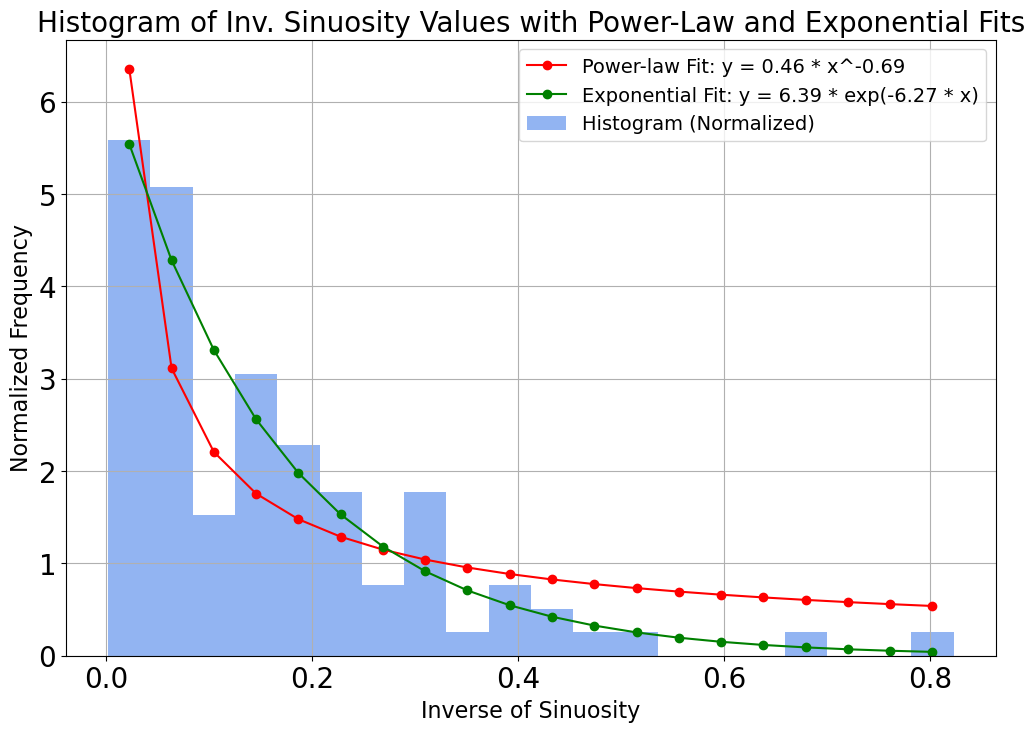

R-squared for Power-law fit: 0.7805
R-squared for Exponential fit: 0.8934


In [1215]:
# Function for power-law: y = a * x^k
def power_law(x, a, k):
    return a * np.power(x, k)

# Function for exponential decay: y = a * exp(-b * x)
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Filter for tracks with avg_inst_velocity > 0.5 pixels/frame and track_duration > 10 frames
filtered_tracks = tp_trajectories_final.groupby('particle').filter(
    lambda group: group['track_duration'].iloc[0] > 10 and group['avg_inst_velocity'].iloc[0] > 0.5
)

# List to store sinuosity results
sinuosity_results = []

# Loop through each particle (track)
for particle_id, group in filtered_tracks.groupby('particle'):
    track_length = group['track_length'].iloc[0]
    x_start = group['x_start'].iloc[0]
    y_start = group['y_start'].iloc[0]
    x_end = group['x_end'].iloc[0]
    y_end = group['y_end'].iloc[0]
    
    straight_distance = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
    sinuosity = straight_distance/track_length   if straight_distance != 0 else np.nan
    sinuosity_results.append(sinuosity)

# Remove NaN values
sinuosity_results = np.array([s for s in sinuosity_results if not np.isnan(s)])

# Plotting the histogram of sinuosity values
if len(sinuosity_results) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate histogram (normalized)
    counts, bin_edges = np.histogram(sinuosity_results, bins=20, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram
    ax.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color='cornflowerblue', alpha=0.7, label='Histogram (Normalized)')

    # Fit the power-law
    popt_power, pcov_power = curve_fit(power_law, bin_centers, counts, maxfev=10000)
    perr_power = np.sqrt(np.diag(pcov_power))  # Standard deviation errors

    # Fit the exponential decay
    popt_exp, pcov_exp = curve_fit(exponential_decay, bin_centers, counts, maxfev=10000)
    perr_exp = np.sqrt(np.diag(pcov_exp))  # Standard deviation errors

    # Plot the fits
    ax.plot(bin_centers, power_law(bin_centers, *popt_power), '-o', color='red', label=f'Power-law Fit: y = {popt_power[0]:.2f} * x^{popt_power[1]:.2f}')
    ax.plot(bin_centers, exponential_decay(bin_centers, *popt_exp), '-o', color='green', label=f'Exponential Fit: y = {popt_exp[0]:.2f} * exp(-{popt_exp[1]:.2f} * x)')

    # Print the fit parameters and their errors
    print("Power-law fit results:")
    print(f"a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")
    print(f"k = {popt_power[1]:.4f} ± {perr_power[1]:.4f}\n")

    print("Exponential fit results:")
    print(f"a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
    print(f"b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")

    # Plot formatting
    ax.set_title('Histogram of Inv. Sinuosity Values with Power-Law and Exponential Fits', fontsize=20)
    ax.set_xlabel('Inverse of Sinuosity', fontsize=16)
    ax.set_ylabel('Normalized Frequency', fontsize=16)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid(True)
    ax.legend(fontsize=14)

    # Show plot
    plt.show()
else:
    print("No tracks with the given criteria.")

# Compute R-squared for power-law and exponential fits
r2_power = r_squared(counts, power_law(bin_centers, *popt_power))
r2_exp = r_squared(counts, exponential_decay(bin_centers, *popt_exp))

# Print R-squared values
print(f"R-squared for Power-law fit: {r2_power:.4f}")
print(f"R-squared for Exponential fit: {r2_exp:.4f}")

In [1185]:
# Calculate R-squared for both fits
def r_squared(y_obs, y_fit):
    ss_res = np.sum((y_obs - y_fit) ** 2)
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)
    return 1 - (ss_res / ss_tot)



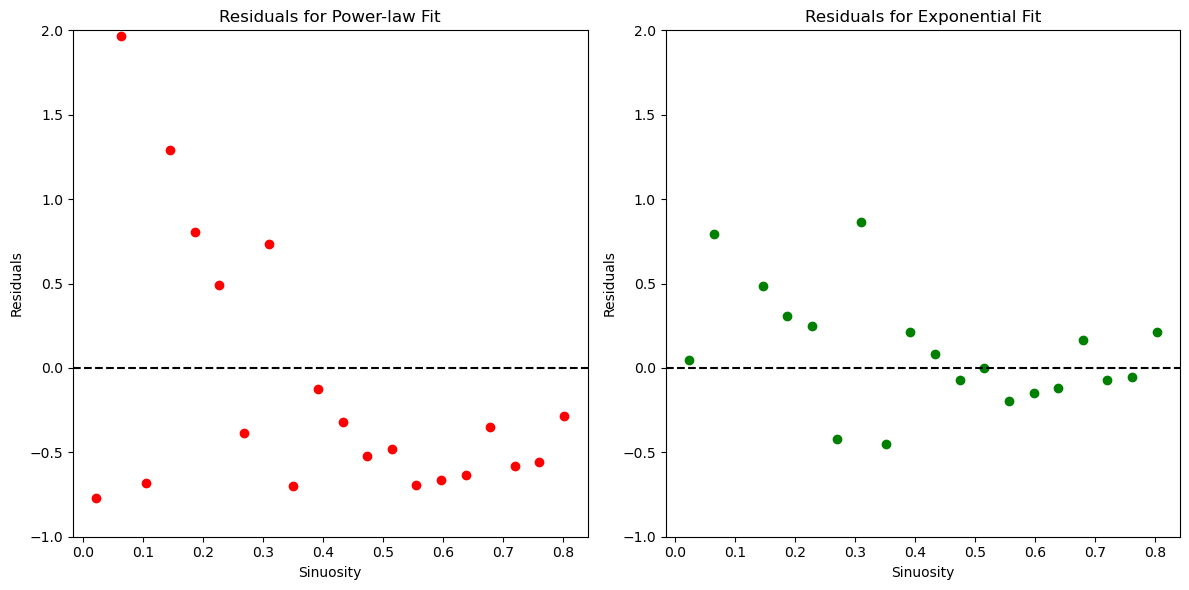

In [1218]:
# Calculate residuals for both fits
residuals_power = counts - power_law(bin_centers, *popt_power)
residuals_exp = counts - exponential_decay(bin_centers, *popt_exp)

# Plotting the residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(bin_centers, residuals_power, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals for Power-law Fit')
plt.ylim([-1, 2])
plt.xlabel('Sinuosity')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(bin_centers, residuals_exp, color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals for Exponential Fit')
plt.xlabel('Sinuosity')
plt.ylabel('Residuals')
plt.ylim([-1, 2])
plt.tight_layout()
plt.show()

# plt.tick_params(axis='both', which='major', labelsize=20)
# plt.tick_params(axis='both', which='minor', labelsize=8)
